In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 输入数据读取与处理
data = pd.read_csv('data/Mobile_Phone_Data_1.csv')
data = data[['timestamp', 'battery_level', 'battery_voltage', 'battery_current', 'battery_power', 'battery_temperature']]
data.columns = ['Time', 'SOC', 'Voltage(V)', 'Current(A)', 'Power(W)', 'Temperature(°C)']

powers = data['Power(W)'].values
powers = np.where(np.abs(powers) < 1.3, 0, powers)
times = data['Time'].values
temps = data['Temperature(°C)'].values
data['Current(A)'] = data['Current(A)']   # 转换为A
# data.head(10000)

# 可爱的参数们
这里整理了模型运行需要的参数，直接在这里修改即可

In [154]:
# 可以修改的参数

# 电池参数
battery_capacity = 5.943 # Ah
# RC单元参数
r0_ref = 0.22 # Ohm
c0_ref = 23.0 # F
# 热力学参数
c_th_default = 1000.0 # J/K
h_default = 10.0 # W/K
# 求OCV函数
t_ref = 23 # 用于ocv的参考温度，摄氏度
t_amb_ref = 23 # 用于热模型的参考环境温度，摄氏度
ocv_offset = 0.1 # OCV整体偏移修正, V
# 温度修正因子
f = 2492.5432
r_ref = 0.05 # 基准内阻，单位欧姆

# OCV模块
对于模型的ocv_func参数，参数名和实际调用的ocv函数关系如下：
- ocv: OCV(SOC), 仅与soc有关
- ocv_t: OCV(SOC, T)，考虑了温度的影响，对预测V(t)的表现会好一点

> ocv_t后面有一个+0.15，是根据图像加的偏移，不然差太多了（）

In [155]:
discharging_23c = pd.read_csv('./data/OCV_SOC_23C_discharging.csv')
discharging_45c = pd.read_csv('./data/OCV_SOC_45C_discharging.csv')
sorted_discharging_23c = discharging_23c.sort_values(by='SOC')
sorted_discharging_45c = discharging_45c.sort_values(by='SOC')

# 基准OCV曲线：23摄氏度下放电曲线，最终选用这个
def ocv_ref_23(soc, table):
    # table.sort_values(by='SOC', inplace=True)
    res = np.interp(soc, table['SOC'], table['OCV(mV)'])
    return res # mV
# 温度敏感系数kt(soc)
def kt(soc, table1, table2, T1, T2):
    ocv1 = ocv_ref_23(soc, table1)
    ocv2 = ocv_ref_23(soc, table2)
    return (ocv2 - ocv1) / (T2 - T1) # mV/°C
# 综合OCV模型
def ocv_t(soc, t):
    k_t = kt(soc, sorted_discharging_23c, sorted_discharging_45c, 23, 45)
    return (ocv_ref_23(soc, sorted_discharging_23c) + k_t * (t - t_ref)) / 1000 + ocv_offset # V
def ocv(soc):
    return ocv_ref_23(soc, sorted_discharging_23c) / 1000 + ocv_offset # V

# discharging_23c.head()

# 核心微分方程组
$$
\begin{equation}
V(t) = \frac{(OCV - V_{RC}) + \sqrt{(OCV - V_{RC})^2 - 4 \cdot P(t) \cdot R_{in}}}{2}
\end{equation}
$$
$$
\begin{equation}
\begin{cases}
\dfrac{dSOC}{dt}
=
-\dfrac{P(t)}{C_1\bigl(T(t),SOH\bigr)\,V(t)}, \\[10pt]
\dfrac{dV_{RC}}{dt}
=
-\dfrac{1}{R_0 C_0}V_{RC}(t)
+
\dfrac{1}{C_0}\,i(t), \\[10pt]
C_{th}\dfrac{dT}{dt}
=
Q_{gen}(t)
-
h\bigl(T(t)-T_{amb}\bigr),
\end{cases}
\end{equation}$$

# 内阻对电学参数的影响
$$
\begin{equation}
R_{in}(T, SOH) = R_{\mathrm{ref}} \cdot f_T(T) \cdot f_{SOH}(SOH),
\end{equation}
$$
$$
\begin{equation}
    f_T(T)= \exp \left[ f \cdot \left( \frac{1}{T} - \frac{1}{T_{\text{ref}}} \right) \right],
\end{equation}
$$

In [156]:
def f_T(temperature):
    return np.exp(f * (1/(temperature + 273.15) - 1/(t_amb_ref + 273.15)))
def f_SOH(soh):
    return np.exp(-3 * (1 - soh)) # mockup
# 等效内阻函数
def r_internal(temp, soh):
    return r_ref * f_T(temp) * f_SOH(soh)

# 模型求解函数

使用前向欧拉法求解，达到了精度和计算效率的平衡

In [157]:
# 主求解函数
def solve_battery_soc(power, times, temperatures, initial_soc, 
                      capacity, r_in, r0, c0, ocv_func, 
                      c_th=1000.0, h=10.0, mode='normal', initial_vrc=0.0):
    """
    求解电热耦合等效电路模型(ECM)，返回SOC-t曲线。

    输入:
        power: array-like, 功率序列 (W), 正值放电, 负值充电
        times: array-like, 时间序列 (s)
        temperatures: array-like, 环境温度序列 (摄氏度)
        initial_soc: float, 初始SOC (0~1)
        capacity: float, 电池容量 (Ah)
        r_in: float or function, 内阻 (Ohm) 或 def r_in(temp, soh)
        r0: float, 极化电阻 (Ohm)
        c0: float, 极化电容 (F)
        ocv_func: function, SOC到OCV的映射函数 def ocv_func(soc)
        c_th: float, 电池热容 (J/K), 默认为1000 (若未提供)
        h: float, 换热系数 (W/K), 默认为10 (若未提供)
        mode: str, 'normal' (常规) 或 'transient' (强瞬态)
        initial_vrc: float, 初始极化电压, 默认为0

    输出:
        soc_curve: np.array, 预测的SOC随时间变化的曲线
    """
    
    # 1. 数据预处理
    N = len(times)
    dt = np.diff(times)
    # 补齐最后一个时间步长，保持数组长度一致
    dt = np.append(dt, dt[-1] if len(dt) > 0 else 1.0)
    
    # 状态变量初始化
    soc = np.zeros(N)
    v_rc = np.zeros(N)
    t_batt = np.zeros(N)
    r_ins = np.zeros(N)
    voltages = np.zeros(N)
    
    soc[0] = initial_soc
    v_rc[0] = initial_vrc
    t_batt[0] = temperatures[0] if len(temperatures) > 0 else 25.0
    
    # 容量单位转换 Ah -> As (Coulombs)
    cap_coulombs = capacity * 3600.0
    
    # 辅助函数：处理内阻是常数还是函数的情况
    if callable(r_in):
        get_rin = r_in
    else:
        get_rin = lambda t, s: r_in

    # 2. 迭代求解
    for k in range(N):
        # --- 获取当前时刻输入 ---
        P_k = power[k]
        T_amb_k = temperatures[k]
        
        # 当前状态
        soc_k = soc[k]
        vrc_k = v_rc[k]
        temp_k = t_batt[k]
        
        # --- 计算代数方程 (电压 & 电流) ---
        # 检查ocv_k是否依赖温度
        if 't' in ocv_func.__code__.co_varnames:
            ocv_k = ocv_func(soc_k, temp_k)
        else:
            ocv_k = ocv_func(soc_k)

        rin_k = get_rin(temp_k, 1.0) # 假设SOH=1，简化处理
        r_ins[k] = rin_k
        
        # 使用二次方程求根公式计算 V(t)
        # V = [ (OCV - Vrc) + sqrt((OCV-Vrc)^2 - 4*P*Rin) ] / 2
        term_base = ocv_k - vrc_k
        discriminant = term_base**2 - 4 * P_k * rin_k
        
        # 物理约束保护：防止根号下为负（电压崩塌）
        if discriminant < 0:
            discriminant = 0 
        
        v_term = (term_base + np.sqrt(discriminant)) / 2.0
        voltages[k] = v_term

        # 计算电流 i(t) = P(t) / V(t)
        # 避免除以零，设定一个极小电压阈值
        if v_term < 1e-4:
            i_t = 0
        else:
            i_t = P_k / v_term
            
        # --- 计算发热量 Q_gen ---
        if mode == 'transient':
            q_gen = (i_t**2) * rin_k + (vrc_k**2) / r0
        else:
            q_gen = (i_t**2) * rin_k
            
        # --- 状态更新 (若不是最后一步) ---
        if k < N - 1:
            step = dt[k]
            
            # 1. 更新 SOC
            # dSOC/dt = -P / (Capacity * V) = -i / Capacity
            d_soc = -i_t / cap_coulombs
            soc[k+1] = soc_k + d_soc * step
            soc[k+1] = np.clip(soc[k+1], 0.0, 1.0) # 物理边界约束
            
            # 2. 更新 V_RC
            # dVrc/dt = -Vrc/(R0*C0) + i/C0
            d_vrc = -(vrc_k / (r0 * c0)) + (i_t / c0)
            v_rc[k+1] = vrc_k + d_vrc * step
            
            # 3. 更新 电池温度 T
            # Cth * dT/dt = Q_gen - h*(T - Tamb)
            d_temp = (q_gen - h * (temp_k - T_amb_k)) / c_th
            t_batt[k+1] = temp_k + d_temp * step
            
    return soc, v_rc, t_batt, r_ins, voltages

# 模型模拟

In [158]:
# 模拟运行
res_soc, res_vrc, res_temp, rins, voltages = solve_battery_soc(-powers, times, temps, 
                                initial_soc=data['SOC'].values[0],
                                capacity=battery_capacity,    # Ah
                                r_in = r_internal,      # Ohm
                                r0=r0_ref,        # Ohm
                                c0=c0_ref,          # F
                                ocv_func=ocv_t,
                                c_th=c_th_default,    # J/K
                                h=h_default,         # W/K
                                mode='transient',
                                initial_vrc=0.0)

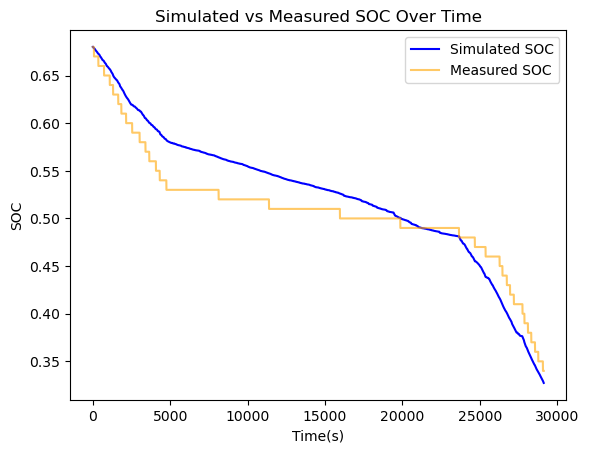

In [159]:
# SOC对比图
# plt.figure(figsize=(12, 6))
sns.lineplot(x=times, y=res_soc, label='Simulated SOC', color='blue')
sns.lineplot(x=times, y=data['SOC'].values, label='Measured SOC', color='orange', alpha=0.6)
plt.xlabel('Time(s)')
plt.ylabel('SOC')
plt.legend()
plt.title('Simulated vs Measured SOC Over Time')
plt.show()

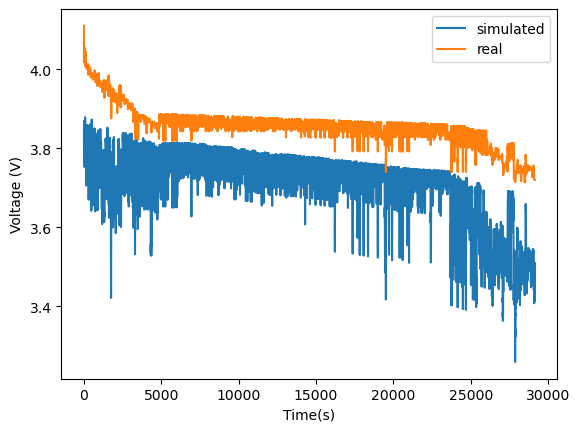

In [160]:
# 电压对比图
plt.plot(times, voltages, label='simulated')
plt.plot(times, data['Voltage(V)'].values, label='real')
plt.xlabel('Time(s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

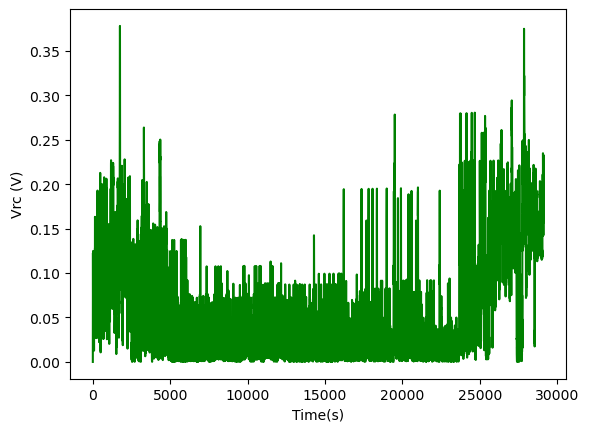

array([0.        , 0.06033817, 0.08936408, 0.10102206, 0.10995071,
       0.10929401, 0.11043274, 0.11226885, 0.12253382, 0.11406092])

In [161]:
# Vrc曲线
plt.plot(times, res_vrc, label='Vrc', color='green')
plt.xlabel('Time(s)')
plt.ylabel('Vrc (V)')
plt.show()
res_vrc[:10]

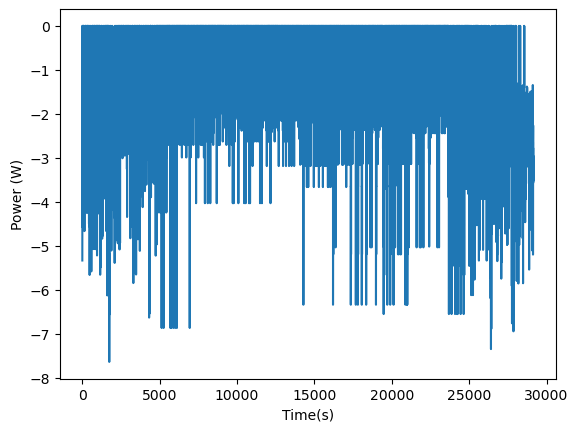

In [162]:
# 功率曲线
# plt.plot(times[5000:7000], powers[5000:7000])
plt.plot(times, powers)
plt.xlabel('Time(s)')
plt.ylabel('Power (W)')
plt.show()

# 误差分析

In [163]:
# 计算误差
from sklearn.metrics import mean_absolute_error, mean_squared_error

def check_accuracy(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    max_err = np.max(np.abs(real - pred))
    
    print(f"--- 准确度评估 ---")
    print(f"MAE  : {mae:.4f} (平均偏差 {mae*100:.2f}%)")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAXE : {max_err:.4f} (最大偏差 {max_err*100:.2f}%)")
    
    return mae, rmse, max_err

check_accuracy(data['SOC'].values, res_soc)

--- 准确度评估 ---
MAE  : 0.0241 (平均偏差 2.41%)
RMSE : 0.0275
MAXE : 0.0523 (最大偏差 5.23%)


(0.02408222223857744,
 np.float64(0.027513457619922844),
 np.float64(0.052324111636786075))

# 模型的灵敏性检验
温度-时间热力学模型：
$$C_{th}\dfrac{dT}{dt}
=
Q_{gen}(t)
-
h\bigl(T(t)-T_{amb}\bigr)$$
常规工况：
$$\begin{equation}
Q_{gen}(t)=i^2(t)\,R_{in}\bigl(T(t),SOH\bigr).
\end{equation}$$
复杂工况：
$$
\begin{equation}
Q_{gen}(t)=i^2(t)\,R_{in}\bigl(T(t),SOH\bigr)+\frac{V_{RC}^2(t)}{R_0}.
\end{equation}$$

采用四组[C_th, h]数据观察参数对模型的作用。


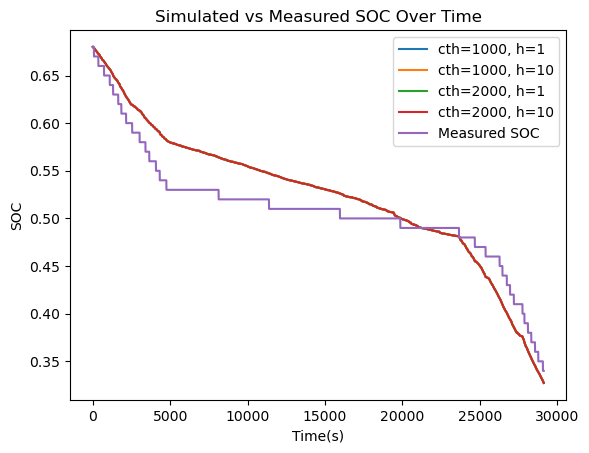

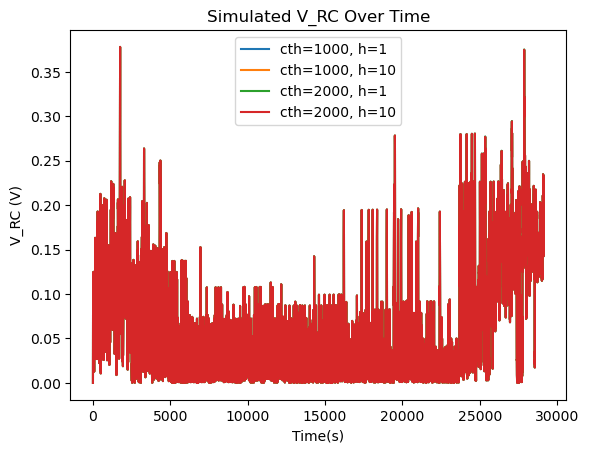

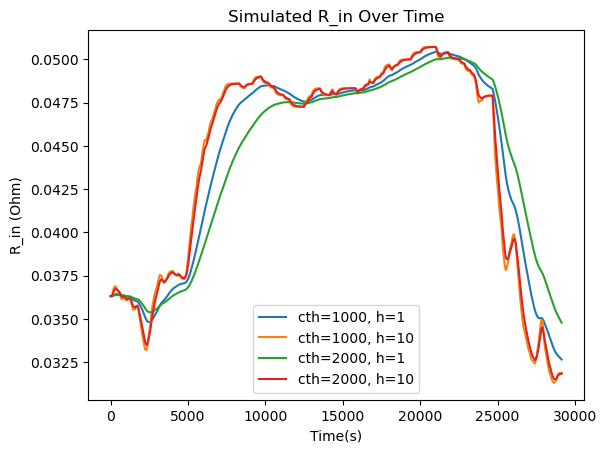

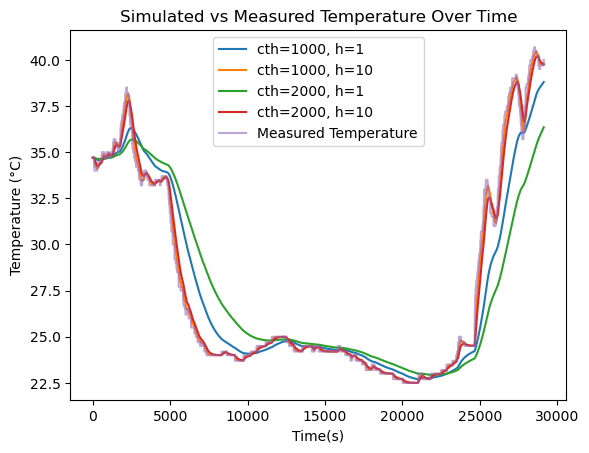

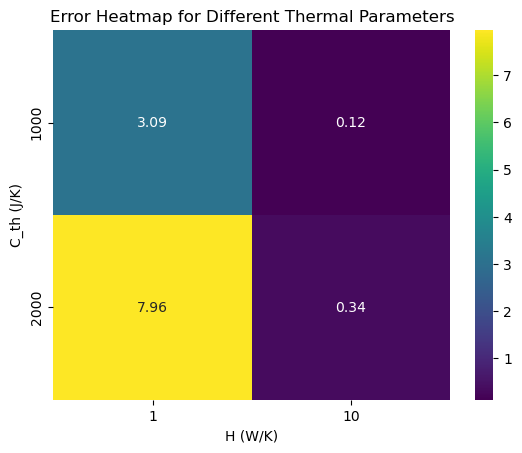

In [164]:
# 热力学参数
# cth_list = [100, 500, 1000,2000, 3000, 4000]
# h_list = [0.1,1,10]
cth_list = [1000, 2000]
h_list = [1,10]
error_list = []
soc_res_list = []
vrc_res_list = []
temp_res_list = []
rins_res_list = []
for c_ in cth_list:
    for h_ in h_list:
        s,v,t,rins,voltages = solve_battery_soc(-powers, times, temps, 
                                initial_soc=data['SOC'].values[0],
                                capacity=battery_capacity,    # Ah
                                r_in = r_internal,      # Ohm
                                r0=r0_ref,        # Ohm
                                c0=c0_ref,          # F
                                ocv_func=ocv_t,
                                c_th=c_,    # J/K
                                h=h_,         # W/K
                                mode='transient',
                                initial_vrc=0.0)
        # sns.lineplot(x=times, y=t, label=f'cth={c_}, h={h_}')
        error = np.mean((t - data['Temperature(°C)'].values)**2)
        error_list.append((c_, h_, error))
        soc_res_list.append((c_, h_, s))
        vrc_res_list.append((c_, h_, v))
        temp_res_list.append((c_, h_, t))
        rins_res_list.append((c_, h_, rins))
# soc曲线
for(c_, h_, s) in soc_res_list:
    sns.lineplot(x=times, y=s, label=f'cth={c_}, h={h_}')
sns.lineplot(x=times, y=data['SOC'].values, label='Measured SOC')
plt.xlabel('Time(s)')
plt.ylabel('SOC')
plt.legend()
plt.title('Simulated vs Measured SOC Over Time')
plt.show()

# vrc曲线
for(c_, h_, v) in vrc_res_list:
    sns.lineplot(x=times, y=v, label=f'cth={c_}, h={h_}')
plt.xlabel('Time(s)')
plt.ylabel('V_RC (V)')
plt.legend()
plt.title('Simulated V_RC Over Time')
plt.show()

# rins曲线
for(c_, h_, r) in rins_res_list:
    sns.lineplot(x=times, y=r, label=f'cth={c_}, h={h_}')
plt.xlabel('Time(s)')
plt.ylabel('R_in (Ohm)')
plt.legend()
plt.title('Simulated R_in Over Time')
plt.show()

# 温度曲线
# plt.plot(times, res_temp, label='Simulated Temperature', color='red')
for(c_, h_, t) in temp_res_list:
    sns.lineplot(x=times, y=t, label=f'cth={c_}, h={h_}')
sns.lineplot(x=times, y=data['Temperature(°C)'].values, label='Measured Temperature', alpha=0.6)
plt.xlabel('Time(s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Simulated vs Measured Temperature Over Time')
plt.show()

# 温度热力图
error_df = pd.DataFrame(error_list, columns=['C_th', 'H', 'Error'])
error_pivot = error_df.pivot(index='C_th', columns='H', values='Error')
sns.heatmap(error_pivot, annot=True, fmt=".2f", cmap='viridis')
plt.title('Error Heatmap for Different Thermal Parameters')
plt.xlabel('H (W/K)')
plt.ylabel('C_th (J/K)')
plt.show()